Convert the output of many Palette c&c runs to netCDF files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr

In [2]:
### Directory management
parent_dir = Path('/scratch/orybchuk/wakedynamics/bcs-ldm/palette_3d/concat_and_cascade/may28/1600')

dir_pattern = '**/2024_05*'
run_dirs = list(parent_dir.glob(dir_pattern))
run_dirs.sort()
n_desired_runs = 30
n_dirs = len(run_dirs)
# run_dirs = run_dirs[n_dirs-n_desired_runs:]  # Run this code if I ran too many c&c jobs
# n_dirs = len(run_dirs)
print("Number of c&c jobs to convert:", n_dirs)
assert n_dirs == n_desired_runs, f"Unexpected number of directories! I was expecting {n_desired_runs}, but got {n_dirs}."

cascade_pattern = '12_to_24'

if parent_dir.name == '1500':
    parent_export_dir_for_tony = Path('/projects/wakedynamics/orybchuk/share/inflow_bcs_from_dm/072415_1/new_batch240528')
elif parent_dir.name == '1530':
    parent_export_dir_for_tony = Path('/projects/wakedynamics/orybchuk/share/inflow_bcs_from_dm/072415_2/new_batch240528')
elif parent_dir.name == '1600':
    parent_export_dir_for_tony = Path('/projects/wakedynamics/orybchuk/share/inflow_bcs_from_dm/072415_3/new_batch240528')

Number of c&c jobs to convert: 30


In [3]:
### Iterate over each c&c job, and save out a netCDF file
ds_cts_list = []  # A collection of continuous Datasets for each run_dir
for i_dir, f_run_dir in enumerate(run_dirs):
    ### ~~~~~ Read the input+mask+reconstruction chunks ~~~~~
    cascade_dir = Path(f_run_dir, cascade_pattern)

    finput_chunks = list(cascade_dir.glob('chunk*/input/data*00.npy'))
    finput_chunks.sort()

    fmask_chunks = list(cascade_dir.glob('chunk*/mask/*.npy'))
    fmask_chunks.sort()

    foutput_chunks = list(cascade_dir.glob('chunk*/output/*.npy'))
    foutput_chunks.sort()
    
    # Chunk parameters
    n_chunks = len(finput_chunks)
    nchan = np.load(finput_chunks[0]).shape[0]
    ntime = np.load(finput_chunks[0]).shape[1]
    nwidth = np.load(finput_chunks[0]).shape[2]
    nheight = np.load(finput_chunks[0]).shape[3]
    
    ### ~~~~~ Create a chunk-level Dataset ~~~~~
    # Get chunks into a list
    input_arrs_list = []
    for i in range(n_chunks):
        tmp_arr = np.load(finput_chunks[i]).copy()
        tmp_arr = tmp_arr[np.newaxis,:,:,:,:]  # Create the chunk axis
        input_arrs_list.append(tmp_arr)

    mask_arrs_list = []
    for i in range(n_chunks):
        tmp_arr = np.load(fmask_chunks[i])
        if nchan == 1:
            tmp_arr = np.squeeze(tmp_arr)[np.newaxis,np.newaxis,:,:,:]  # Reshape the mask
        else:
            tmp_arr = np.squeeze(tmp_arr)[np.newaxis,:,:,:]  # Reshape the mask
        mask_arrs_list.append(tmp_arr.copy())

    output_arrs_list = []
    for i in range(n_chunks):
        tmp_arr = np.load(foutput_chunks[i]).copy()
        tmp_arr = tmp_arr[np.newaxis,:,:,:,:]  # Create the chunk axis
        output_arrs_list.append(tmp_arr)

    # List to numpy array
    input_arrs = np.concatenate(input_arrs_list)
    mask_arrs = np.concatenate(mask_arrs_list)
    output_arrs = np.concatenate(output_arrs_list)

    mask_arrs[mask_arrs == 1.0] = np.nan  # NaN in mask arrays
    mask_arrs += 1

    # Get numpy array into xarray
    coords_chunk = {'chunk': range(n_chunks),
              'time': range(ntime),
              'width': range(nwidth),
              'height': range(nheight)}
    ds_chunk = xr.Dataset(coords=coords_chunk)
    vardict = {0: 'u', 1:'v', 2:'w', 3:'T', 4:'TKE'}

    for ivar in range(nchan):
        varname = vardict[ivar]
        curr_inp = input_arrs[:,ivar,:,:,:]
        if nchan == 1:
            curr_mask = mask_arrs[:,ivar,:,:,:]
        else:
            curr_mask = mask_arrs[:,:,:,:,ivar]
        curr_out = output_arrs[:,ivar,:,:,:]
        ds_chunk[f'{varname}_input'] = (('chunk', 'time', 'width', 'height'), curr_inp)
        ds_chunk[f'{varname}_mask'] = (('chunk', 'time', 'width', 'height'), curr_mask)
        ds_chunk[f'{varname}_output'] = (('chunk', 'time', 'width', 'height'), curr_out)
        
    ### ~~~~~ Create a continuous Dataset ~~~~~
    ## Parameters
    stride_len = 32
    ntime_cts = (n_chunks+1) * stride_len
    dt = 1.0

    ## Initialize arrays
    input_cts = np.zeros((nchan, ntime_cts, nwidth, nheight))
    mask_cts = np.zeros((nchan, ntime_cts, nwidth, nheight))
    output_cts = np.zeros((nchan, ntime_cts, nwidth, nheight))

    ## Manually populate for chunk 0
    ichunk = 0
    for ichan in range(nchan):
        varname = vardict[ichan]
        input_cts[ichan,0:2*stride_len,:,:] = ds_chunk[f'{varname}_input'].isel(chunk=ichunk).values
        mask_cts[ichan,0:2*stride_len,:,:] = ds_chunk[f'{varname}_mask'].isel(chunk=ichunk).values
        output_cts[ichan,0:2*stride_len,:,:] = ds_chunk[f'{varname}_output'].isel(chunk=ichunk).values

    ## Populate for remaining chunks
    for ichunk in range(1, n_chunks):
        start_ind_cts = (ichunk+1)*stride_len
        end_ind_cts = start_ind_cts + stride_len

        for ichan in range(nchan):
            varname = vardict[ichan]

            input_cts[ichan,start_ind_cts:end_ind_cts,:,:] = ds_chunk[f'{varname}_input'].isel(chunk=ichunk, time=slice(stride_len, 2*stride_len)).values
            mask_cts[ichan,start_ind_cts:end_ind_cts,:,:] = ds_chunk[f'{varname}_mask'].isel(chunk=ichunk, time=slice(stride_len, 2*stride_len)).values
            output_cts[ichan,start_ind_cts:end_ind_cts,:,:] = ds_chunk[f'{varname}_output'].isel(chunk=ichunk, time=slice(stride_len, 2*stride_len)).values

    ## Get into Xarray
    coords_cts = {'ens': [f_run_dir.name],
              'time': np.arange(dt*ntime_cts),
              'width': range(nwidth),
              'height': range(nheight)}
    ds_cts = xr.Dataset(coords=coords_cts)
    
    for ichan in range(nchan):
        varname = vardict[ichan]
        curr_inp = input_cts[ichan,:,:,:]
        curr_mask = mask_cts[ichan,:,:,:]
        curr_out = output_cts[ichan,:,:,:]
        ds_cts[f'{varname}_input'] = (('time', 'width', 'height'), curr_inp)
        ds_cts[f'{varname}_mask'] = (('time', 'width', 'height'), curr_mask)
        ds_cts[f'{varname}_output'] = (('time', 'width', 'height'), curr_out)
        
    ### ~~~~~ Export to each invididual directory ~~~~~
    f_out = Path(f_run_dir, f'concatenated_inflow_bc_{cascade_pattern}.nc')
    # ds_cts.to_netcdf(f_out)
    ds_cts_list.append(ds_cts.copy())
    
    # Export for Tony
    export_dir_for_tony = Path(parent_export_dir_for_tony, f'network240316_ensemble{str(i_dir).zfill(3)}')
    export_dir_for_tony.mkdir(exist_ok=True)
    ds_cts.to_netcdf(Path(export_dir_for_tony, f'concatenated_inflow_bc_{cascade_pattern}.nc'))

### ~~~~~ Combine all continuous datasets into one large dataset ~~~~~
ds_all_inflows = xr.concat(ds_cts_list, dim='ens')
ds_all_inflows.to_netcdf(f'sampling_output/may28/{parent_dir.name}/inflow_ensemble_from_10b.nc')

# Visual sanity checks

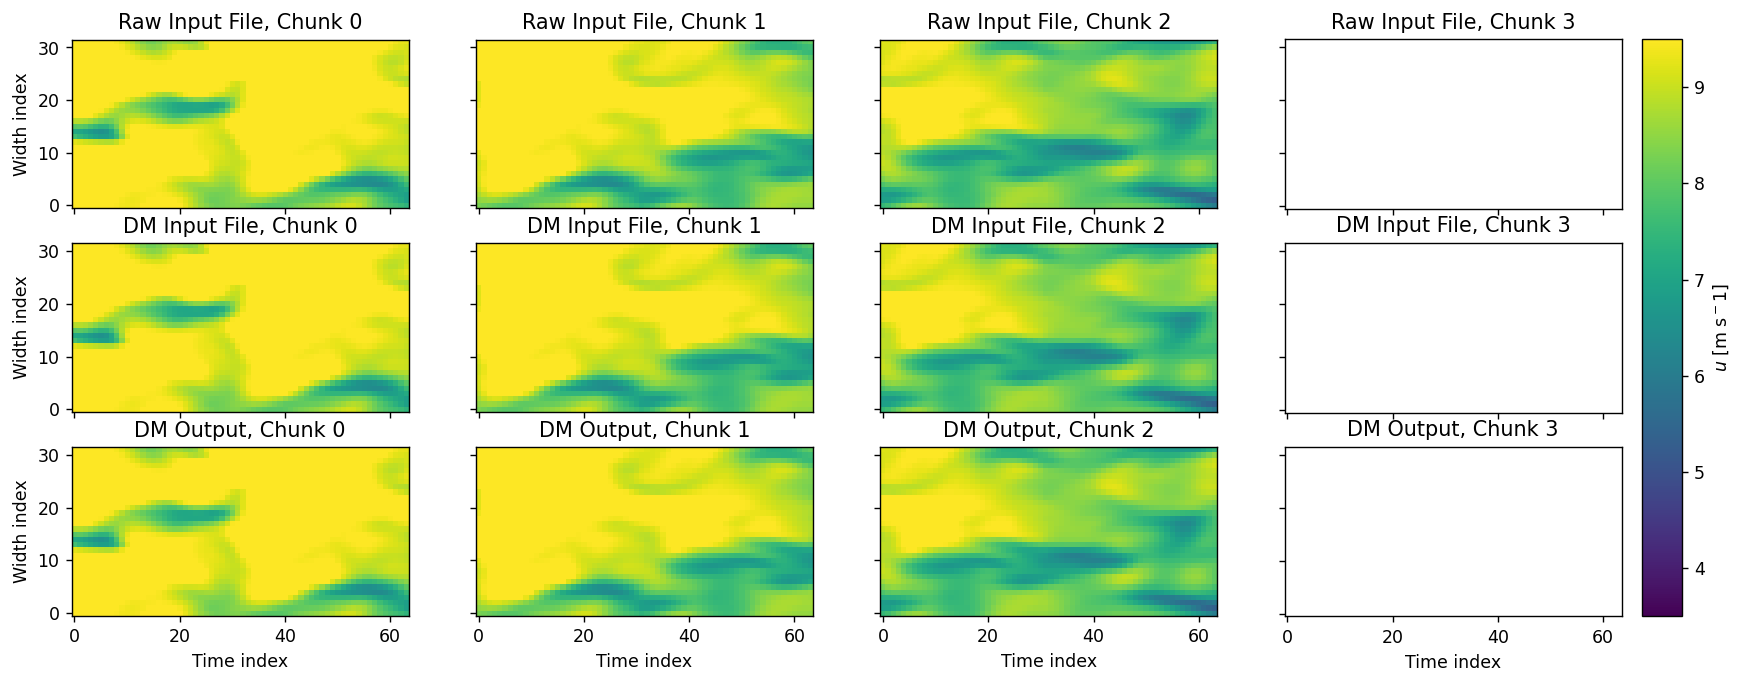

In [4]:
### Top-down view at lidar hub height
fig, ax = plt.subplots(3, 4, figsize=(16,6), sharex=True, sharey=True, dpi=125)

## Decorate
for ichunk in range(4):
    ax[0,ichunk].set_title(f"Raw Input File, Chunk {ichunk}")
    ax[1,ichunk].set_title(f"DM Input File, Chunk {ichunk}")
    ax[2,ichunk].set_title(f"DM Output, Chunk {ichunk}")

for axs in ax[:,0]:
    axs.set_ylabel("Width index")
for axs in ax[-1,:]:
    axs.set_xlabel("Time index")
    
varname = 'u'
vmin, vmax = 3.5, 9.5
kplt = 3

## Plot
for ichunk in range(3):
    im0 = ax[0,ichunk].imshow(ds_chunk[f'{varname}_input'].isel(chunk=ichunk, height=kplt).values.T,
                   origin='lower',
                   vmin=vmin,
                   vmax=vmax)
    ax[1,ichunk].imshow(ds_chunk[f'{varname}_mask'].isel(chunk=ichunk, height=kplt).values.T*ds_chunk['u_input'].isel(chunk=ichunk, height=kplt).values.T,
                   origin='lower',
                   vmin=vmin,
                   vmax=vmax)
    ax[2,ichunk].imshow(ds_chunk[f'{varname}_output'].isel(chunk=ichunk, height=kplt).values.T,
                   origin='lower',
                   vmin=vmin,
                   vmax=vmax)

## Colorbar
cax0 = fig.add_axes([ax[0,-1].get_position().x1+0.01,
                     ax[-1,-1].get_position().y0,
                     0.02,
                     ax[0,-1].get_position().y1-ax[-1,-1].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label(f'${varname}$ [m s$^{-1}$]')
cbar0.ax.tick_params()
    
plt.show()

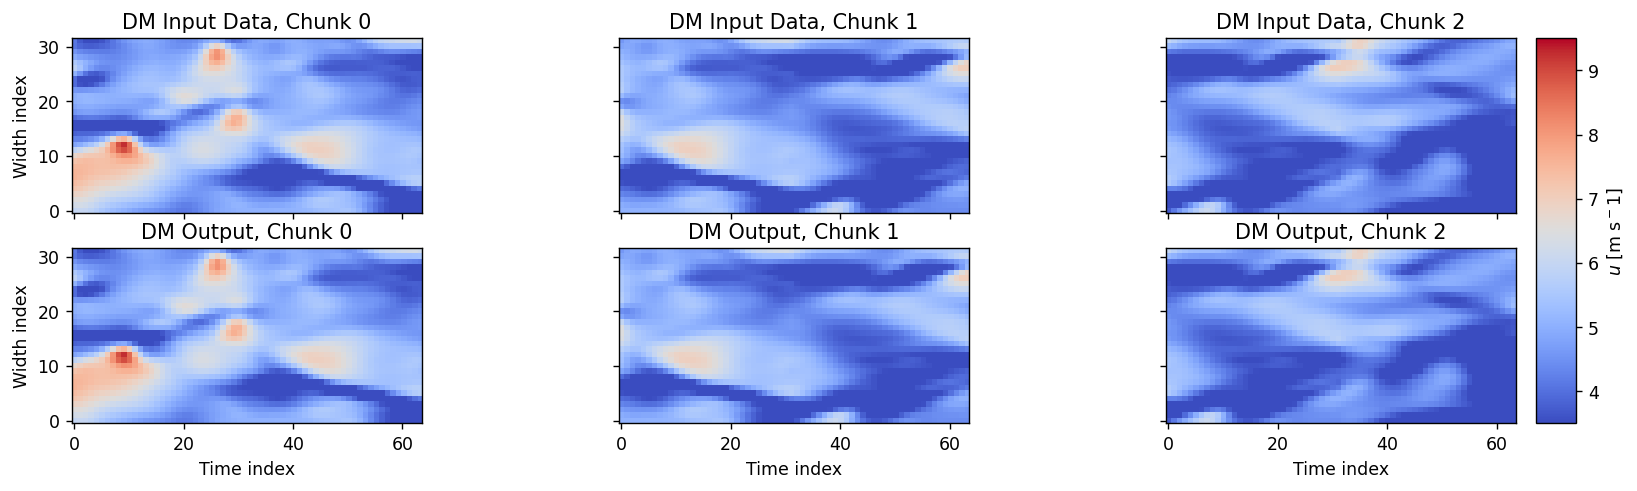

In [5]:
### Top-down view at lidar hub height
fig, ax = plt.subplots(2, 3, figsize=(16,4), sharex=True, sharey=True, dpi=125)

## Decorate
for ichunk in range(3):
#     ax[0,ichunk].set_title(f"Raw Input File, Chunk {ichunk}")
    ax[0,ichunk].set_title(f"DM Input Data, Chunk {ichunk}")
    ax[1,ichunk].set_title(f"DM Output, Chunk {ichunk}")

for axs in ax[:,0]:
    axs.set_ylabel("Width index")
for axs in ax[-1,:]:
    axs.set_xlabel("Time index")
    
varname = 'u'
vmin, vmax = 3.5, 9.5
kplt = 0

## Plot
for ichunk in range(3):
#     im0 = ax[0,ichunk].imshow(ds_chunk[f'{varname}_input'].isel(chunk=ichunk, height=kplt).values.T,
#                    origin='lower',
#                    vmin=vmin,
#                    vmax=vmax)
    im0 = ax[0,ichunk].imshow(ds_chunk[f'{varname}_mask'].isel(chunk=ichunk, height=kplt).values.T*ds_chunk['u_input'].isel(chunk=ichunk, height=kplt).values.T,
                   origin='lower',
                   vmin=vmin,
                   vmax=vmax,
                   cmap='coolwarm')
    ax[1,ichunk].imshow(ds_chunk[f'{varname}_output'].isel(chunk=ichunk, height=kplt).values.T,
                   origin='lower',
                   vmin=vmin,
                   vmax=vmax,
                   cmap='coolwarm')

## Colorbar
cax0 = fig.add_axes([ax[0,-1].get_position().x1+0.01,
                     ax[-1,-1].get_position().y0,
                     0.02,
                     ax[0,-1].get_position().y1-ax[-1,-1].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label(f'${varname}$ [m s$^{-1}$]')
cbar0.ax.tick_params()
    
# plt.savefig('demo_chunked_io.png', bbox_inches='tight')
    
plt.show()

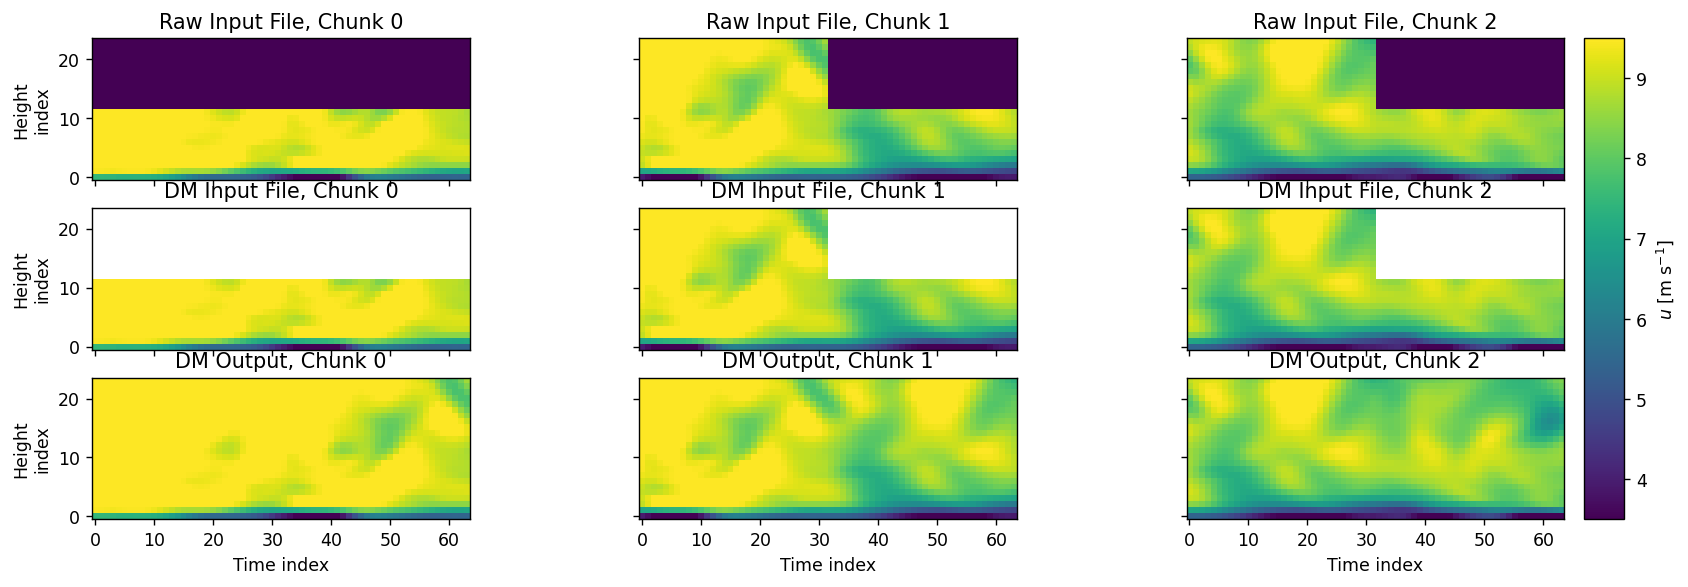

In [6]:
### Side view
fig, ax = plt.subplots(3, 3, figsize=(16,5), sharex=True, sharey=True, dpi=125)

## Decorate
for ichunk in range(3):
    ax[0,ichunk].set_title(f"Raw Input File, Chunk {ichunk}")
    ax[1,ichunk].set_title(f"DM Input File, Chunk {ichunk}")
    ax[2,ichunk].set_title(f"DM Output, Chunk {ichunk}")

for axs in ax[:,0]:
    axs.set_ylabel("Height\nindex")
for axs in ax[-1,:]:
    axs.set_xlabel("Time index")
    
vmin, vmax = 3.5, 9.5
jplt = 8

## Plot
for ichunk in range(3):
    im0 = ax[0,ichunk].imshow(ds_chunk['u_input'].isel(chunk=ichunk, width=jplt).values.T,
                   origin='lower',
                   vmin=vmin,
                   vmax=vmax)
    ax[1,ichunk].imshow(ds_chunk['u_mask'].isel(chunk=ichunk, width=jplt).values.T*ds_chunk['u_input'].isel(chunk=ichunk, width=jplt).values.T,
                   origin='lower',
                   vmin=vmin,
                   vmax=vmax)
    ax[2,ichunk].imshow(ds_chunk['u_output'].isel(chunk=ichunk, width=jplt).values.T,
                   origin='lower',
                   vmin=vmin,
                   vmax=vmax)

## Colorbar
cax0 = fig.add_axes([ax[0,-1].get_position().x1+0.01,
                     ax[-1,-1].get_position().y0,
                     0.02,
                     ax[0,-1].get_position().y1-ax[-1,-1].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label('$u$ [m s$^{-1}$]')
cbar0.ax.tick_params()
    
plt.show()

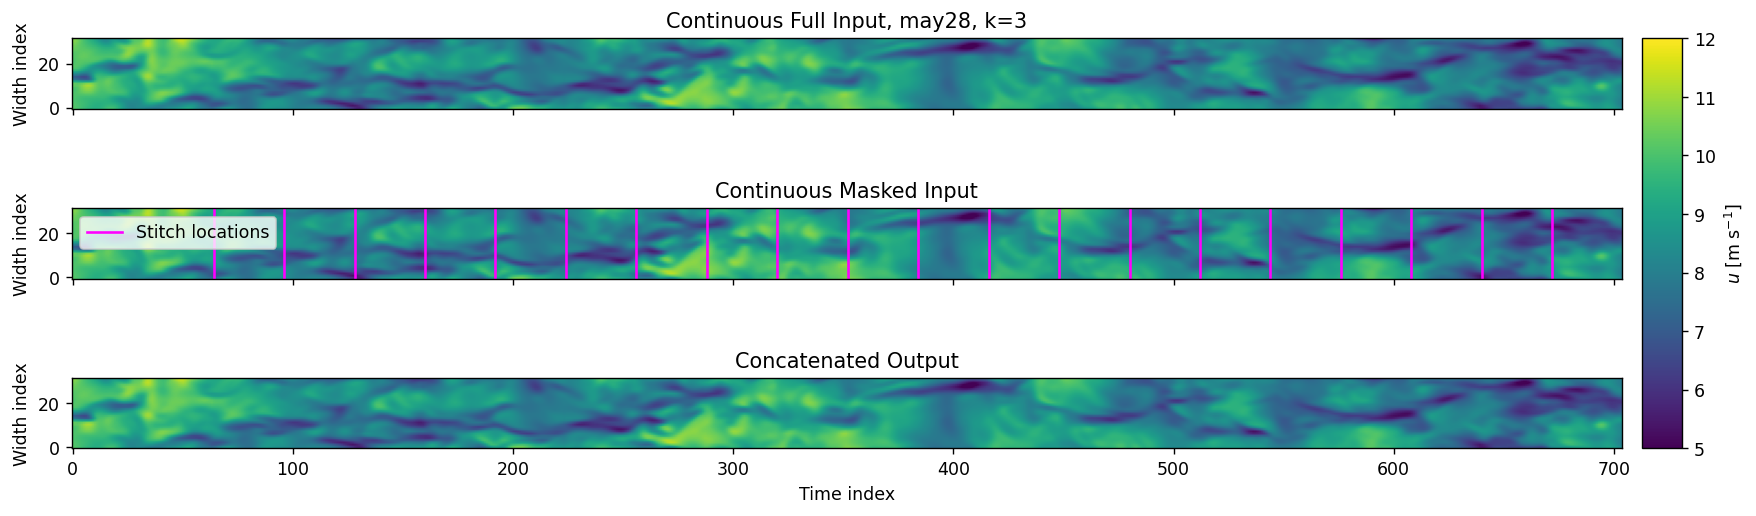

In [7]:
### Top-down view at lidar hub height
fig, ax = plt.subplots(3, 1, figsize=(16,5), sharex=True, sharey=True, dpi=125)

# kplt = 23
kplt = 3

## Decorate
ax[0].set_title(f"Continuous Full Input, {parent_dir.parent.name}, k={kplt}")
ax[1].set_title(f"Continuous Masked Input")
ax[2].set_title(f"Concatenated Output")

for axs in ax:
    axs.set_ylabel("Width index")
ax[-1].set_xlabel("Time index")    

## Plot
varname = 'u'
pltmean = np.nanmean(ds_cts[f'{varname}_output'].isel(height=kplt).values)
# pltmin, pltmax = pltmean - 3, pltmean + 3
pltmin, pltmax = 5, 12

im0 = ax[0].imshow(ds_cts[f'{varname}_input'].isel(height=kplt).values.T,
               origin='lower',
               vmin=pltmin,
               vmax=pltmax)
ax[1].imshow(ds_cts[f'{varname}_mask'].isel(height=kplt).values.T*ds_cts['u_input'].isel(height=kplt).values.T,
               origin='lower',
               vmin=pltmin,
               vmax=pltmax)
ax[2].imshow(ds_cts[f'{varname}_output'].isel(height=kplt).values.T,
               origin='lower',
               vmin=pltmin,
               vmax=pltmax)

# Add marks for where concatenation occurs
for ichunk in range(2, n_chunks+1):
    if ichunk == 2:
        ax[1].axvline(ichunk*stride_len, color='magenta', label='Stitch locations')
    else:
        ax[1].axvline(ichunk*stride_len, color='magenta')
ax[1].legend()
    
## Colorbar
cax0 = fig.add_axes([ax[0].get_position().x1+0.01,
                     ax[-1].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[-1].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label('$u$ [m s$^{-1}$]')
cbar0.ax.tick_params()
    
# plt.savefig('demo_concat_top_down_view2.png', bbox_inches='tight')
    
plt.show()

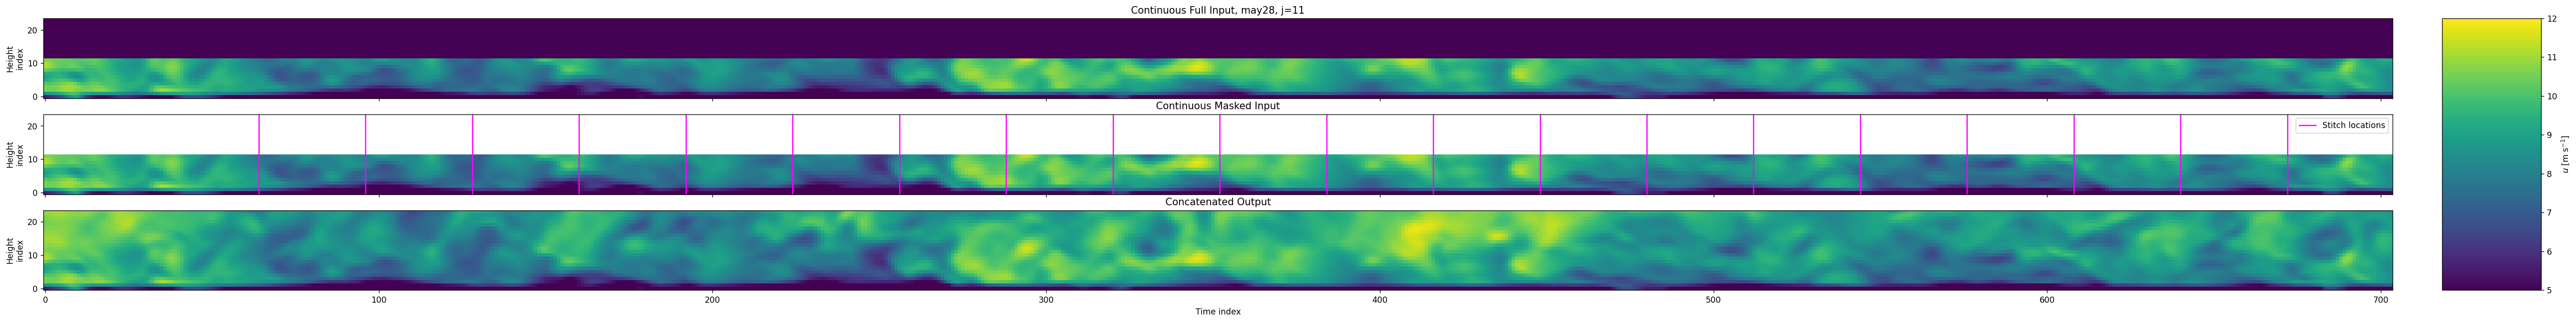

In [8]:
### Side view
fig, ax = plt.subplots(3, 1, figsize=(n_chunks*4,6), sharex=True, sharey=True, dpi=125)

jplt = 11

## Decorate
ax[0].set_title(f"Continuous Full Input, {parent_dir.parent.name}, j={jplt}")
ax[1].set_title(f"Continuous Masked Input")
ax[2].set_title(f"Concatenated Output")

for axs in ax:
    axs.set_ylabel("Height\nindex")
ax[-1].set_xlabel("Time index")

# ax[0].set_xlim(0, 180)

## Plot
varname = 'u'
pltmean = np.nanmean(ds_cts[f'{varname}_output'].isel(width=jplt).values)
pltmin, pltmax = pltmean - 3, pltmean + 3
# pltmin, pltmax = 5, 12

ax[0].imshow(ds_cts[f'{varname}_input'].isel(width=jplt).values.T,
               origin='lower',
               vmin=pltmin,
               vmax=pltmax)
ax[1].imshow(ds_cts[f'{varname}_mask'].isel(width=jplt).values.T*ds_cts['u_input'].isel(width=jplt).values.T,
               origin='lower',
               vmin=pltmin,
               vmax=pltmax)
ax[2].imshow(ds_cts[f'{varname}_output'].isel(width=jplt).values.T,
               origin='lower',
               vmin=pltmin,
               vmax=pltmax)

# Add marks for where concatenation occurs
for ichunk in range(2, n_chunks+1):
    if ichunk == 2:
        ax[1].axvline(ichunk*stride_len, color='magenta', label='Stitch locations')
    else:
        ax[1].axvline(ichunk*stride_len, color='magenta')
ax[1].legend()
    
## Colorbar
cax0 = fig.add_axes([ax[0].get_position().x1+0.01,
                     ax[-1].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[-1].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label('$u$ [m s$^{-1}$]')
cbar0.ax.tick_params()
    
# plt.savefig('demo_concat_side_view2.png', bbox_inches='tight')
    
plt.show()